In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, pairwise_distances, f1_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

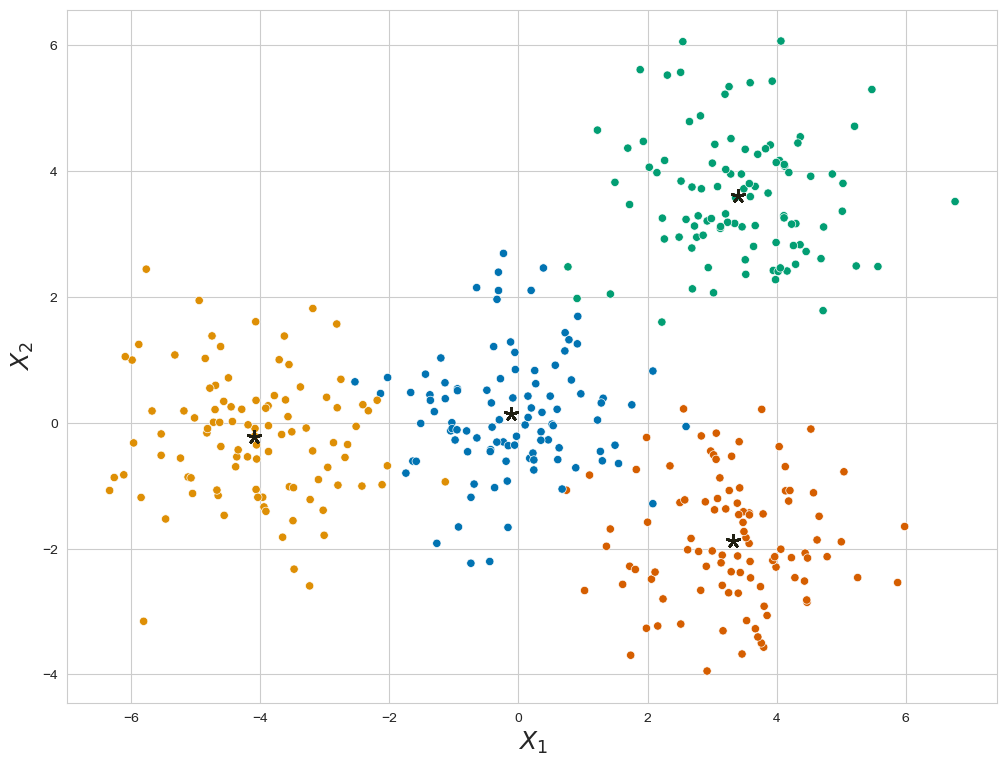

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=20, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        cluster_labels = np.argmin(np.array([self._calculate_distance(X, centroid) for centroid in self.centroids]), axis = 0)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist = np.linalg.norm(X - centroid, axis=1)
        dist = dist[:, np.newaxis] 
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

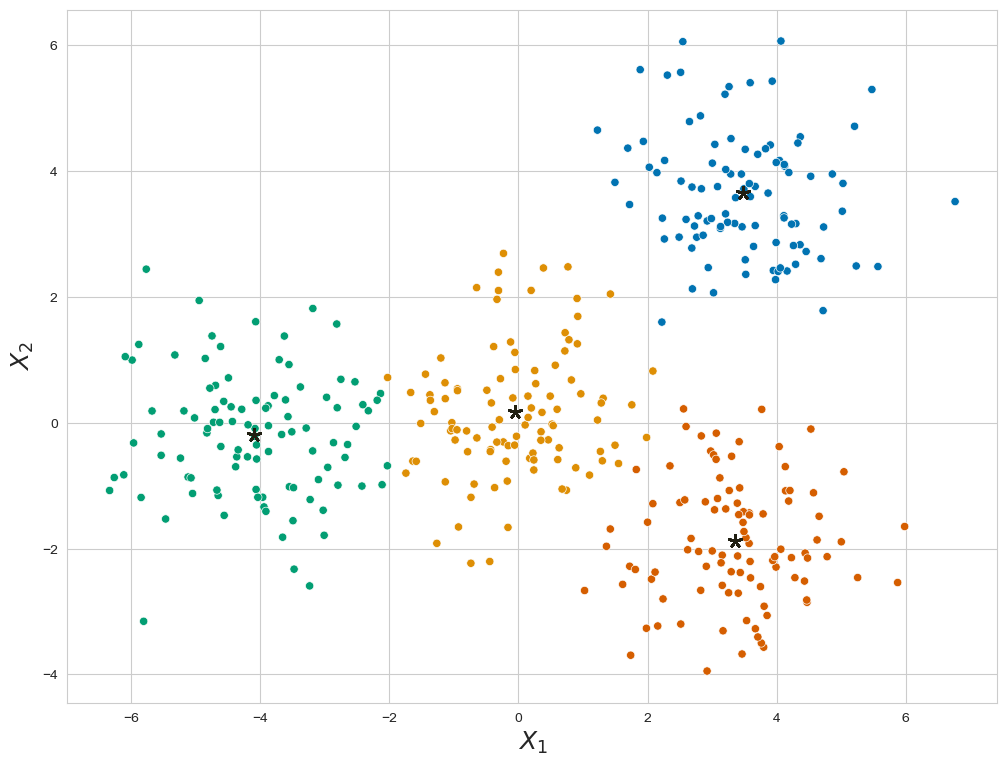

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
# Инициализация и обучение MyKMeans с random инициализацией
kmeans_random = MyKMeans(n_clusters=4, init="random", max_iter=20, visualize=True)
kmeans_random.fit(X)

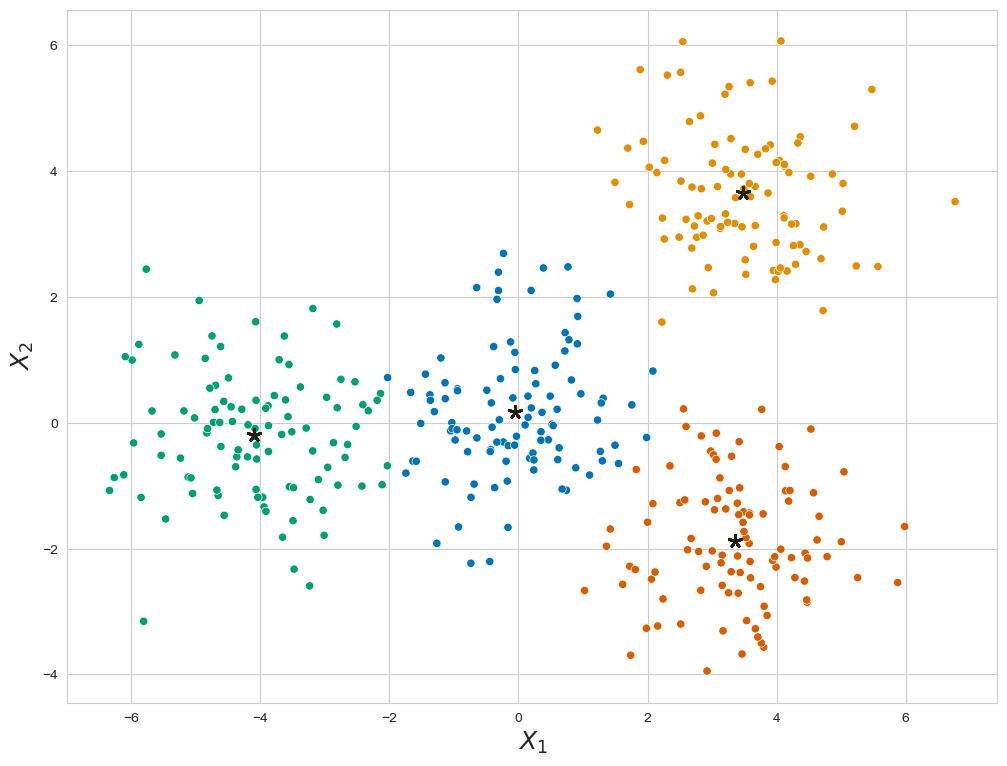

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [8]:
# Инициализация и обучение MyKMeans с sample инициализацией
kmeans_sample = MyKMeans(n_clusters=4, init="sample", max_iter=20, visualize=True)
kmeans_sample.fit(X)

В данном случае оба способа работают одинаково хорошо. Обычно инициализация **sample** дает более стабильные и быстрые результаты, так как начальные центроиды выбираются из реальных данных и меньше зависят от случайности. **Рандомно** центроиды стараются не выбирать, т.к. есть вероятность того что эти точки будут принадлежать к одному классу и нормальной кластеризации не получится.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [9]:
data = load_digits()
X, y = data.data, data.target

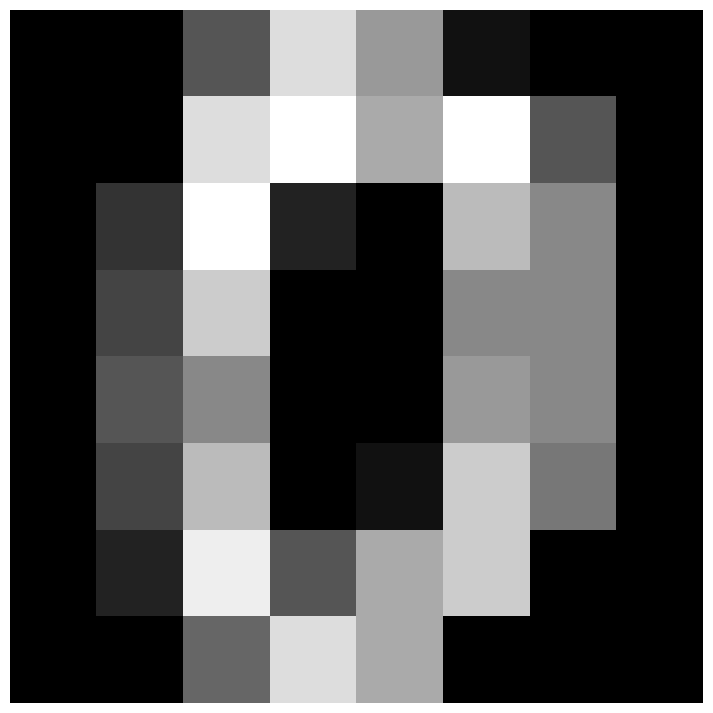

In [10]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [11]:
def algorithm_selection(X, y, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    results = []
    for distance in distances:
        # Вычисляем матрицу попарных расстояний
        if distance in ['manhattan', 'cosine', 'minkowski']:
            X_dist = pairwise_distances(X, metric=distance)
            metric = 'precomputed'
        else:
            X_dist = X
            metric = distance

        for algorithm in algorithms:
            clustering = AgglomerativeClustering(n_clusters=len(np.unique(y)), linkage=algorithm, metric=metric)
            if metric == 'precomputed':
                cluster_labels = clustering.fit_predict(X_dist)
            else:
                cluster_labels = clustering.fit_predict(X)

            # Метрики качества
            scores = {
                'distance': distance,
                'linkage': algorithm,
                'homogeneity': homogeneity_score(y, cluster_labels) if 'Homogeneity' in metrics else None,
                'completeness': completeness_score(y, cluster_labels) if 'Completeness' in metrics else None,
                'v_measure': v_measure_score(y, cluster_labels) if 'V-measure' in metrics else None,
                'silhouette': silhouette_score(X, cluster_labels) if 'Silhouette' in metrics else None
            }
            results.append(scores)

    compare_dataframe = pd.DataFrame(results)
    
    return compare_dataframe

In [12]:
distances = ['manhattan', 'euclidean', 'minkowski', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']

compare_results = algorithm_selection(X, y, distances, algorithms, metrics)
print(compare_results)

     distance   linkage  homogeneity  completeness  v_measure  silhouette
0   manhattan   average     0.566751      0.778942   0.656117    0.089217
1   manhattan    single     0.005102      0.276237   0.010019   -0.166627
2   manhattan  complete     0.646372      0.686109   0.665648    0.140183
3   euclidean   average     0.655393      0.782342   0.713263    0.146625
4   euclidean    single     0.005056      0.273755   0.009929   -0.133621
5   euclidean  complete     0.590549      0.637772   0.613253    0.119271
6   minkowski   average     0.655393      0.782342   0.713263    0.146625
7   minkowski    single     0.005056      0.273755   0.009929   -0.133621
8   minkowski  complete     0.590549      0.637772   0.613253    0.119271
9      cosine   average     0.648268      0.808762   0.719676    0.129526
10     cosine    single     0.005050      0.273389   0.009916   -0.158250
11     cosine  complete     0.528727      0.577415   0.551999    0.088021


Наилучшими алгоритмомами кластеризации с лучшими гиперпараметрами можно считать методы расстояния **minkowski**, **cosine** и **euclidean** c **average** linkage, так как они показали наилучшие результаты по всем рассмотренным метрикам. Также стоит отметить, что для метрики **minkowski** по умолчанию используется p=2, что эквивалентно евклидовому расстоянию, поэтому эти метрики получились одинаковыми.


### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [13]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [14]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [15]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [16]:
# Определим количество клеток и признаков
n_cells, n_features = fc_data.shape
print(f"Количество клеток: {n_cells}")
print(f"Количество признаков: {n_features}")

Количество клеток: 10000
Количество признаков: 9


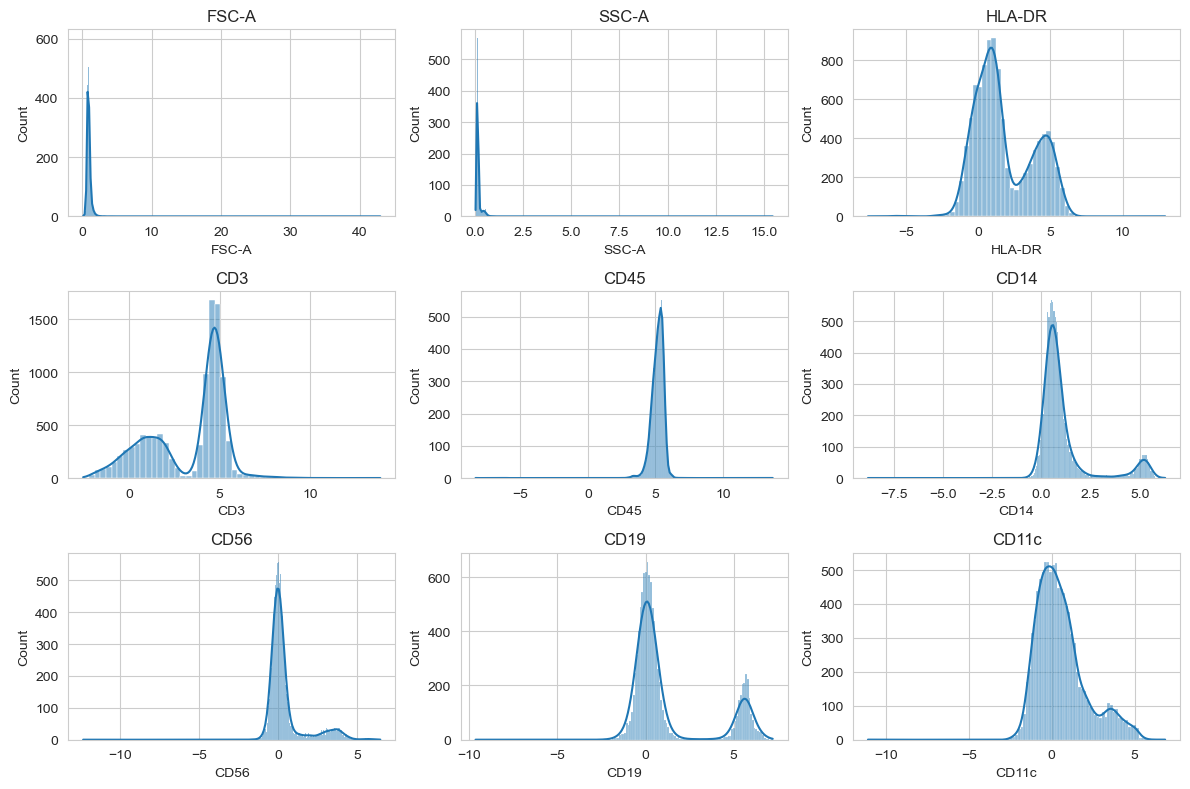

In [17]:
# Посмотрим на распределение признаков
plt.figure(figsize=(12, 8))
for i, column in enumerate(fc_data.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(fc_data[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

Почти на всех графиках, которые измеряют интенсивность флуоресценции прослеживается 2 пика (кроме CD45), что возможно указывает на 2 популяции клеток

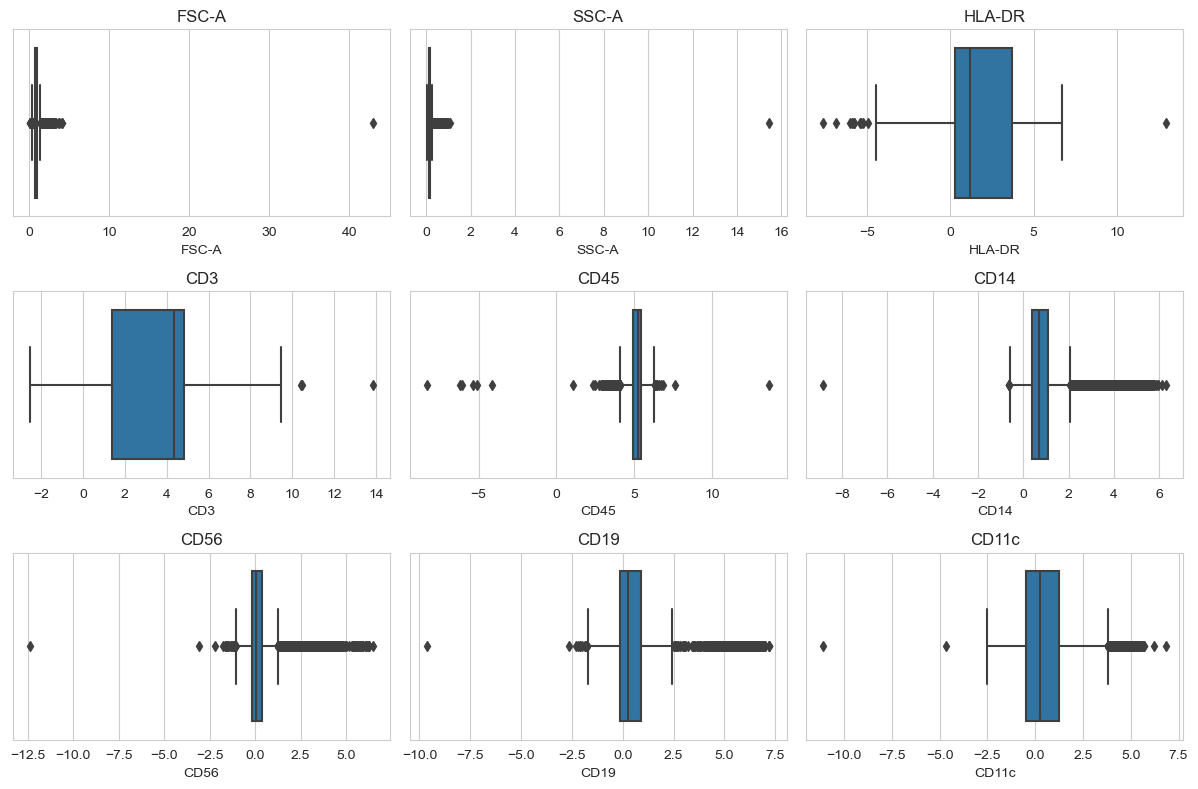

In [18]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(fc_data.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(fc_data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

По графику видно, что одно значение очень сильно выбивается. Удалим значение, при котором FSC-A равняется 42.954485, т.к. данное наблюдение является выбросом.

In [19]:
fc_data = fc_data[fc_data['FSC-A'] != 42.954485]

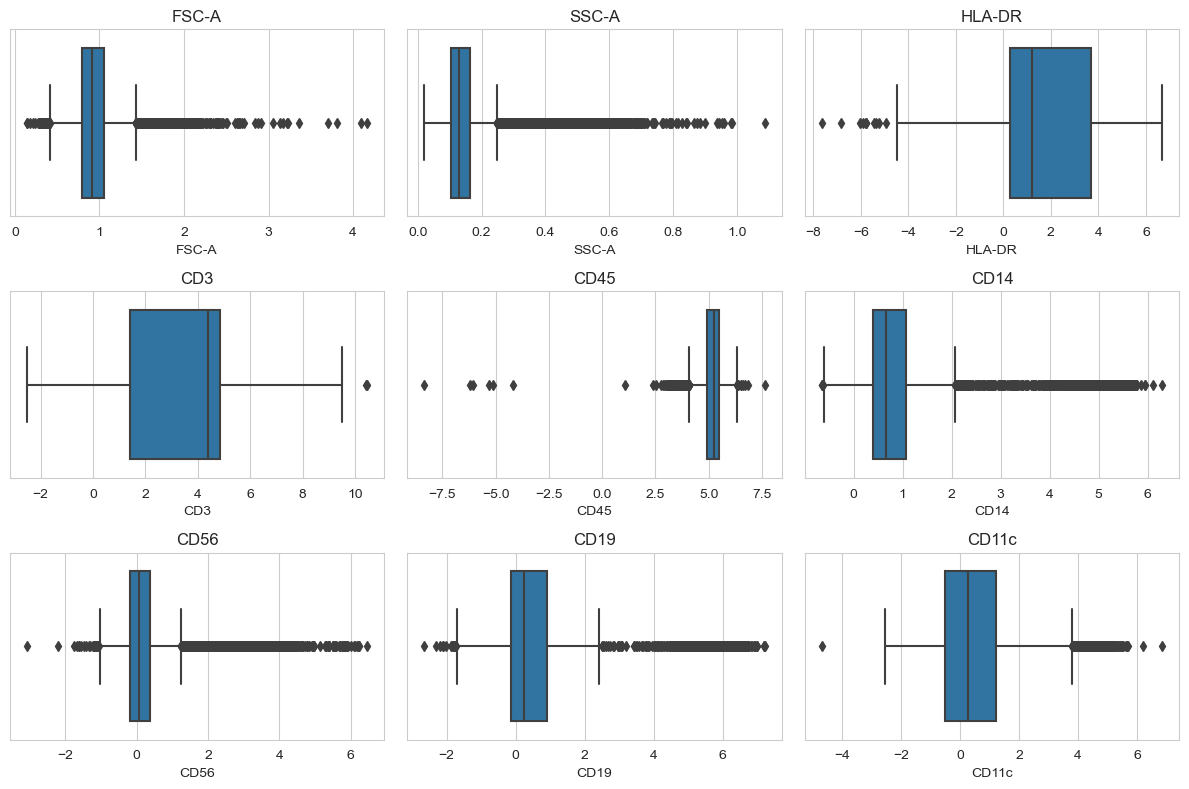

In [20]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(fc_data.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(fc_data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

Теперь очевидных выбросов нет.

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [21]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

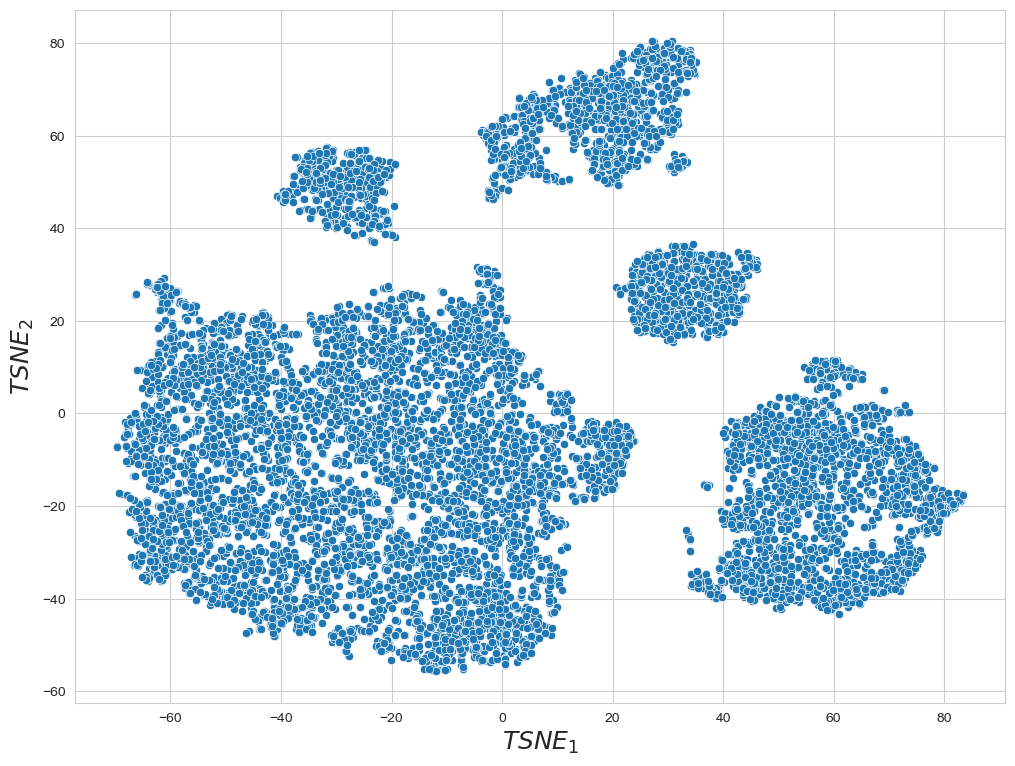

In [22]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [23]:
# Определение параметров для анализа
distances = ['euclidean', 'manhattan', 'cosine']  
linkages = ['single', 'complete', 'average', 'ward']
results = []

# Перебор различных метрик расстояния и методов linkage для AgglomerativeClustering
for distance in distances:
    for linkage in linkages:
        if linkage == 'ward' and distance != 'euclidean': # ward может работать только с эвклидовым расстоянием
            continue

        # Инициализация и обучение AgglomerativeClustering
        clustering = AgglomerativeClustering(n_clusters=4, metric=distance, linkage=linkage)
        labels = clustering.fit_predict(fc_data)
        score = silhouette_score(fc_data, labels)
        
        results.append({
            'algorithm': 'AgglomerativeClustering',
            'distance': distance,
            'linkage': linkage,
            'silhouette_score': score
        })

# Перебор различных метрик расстояния для KMeans (использует только евклидово расстояние)
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(fc_data)
kmeans_score = silhouette_score(fc_data, kmeans_labels)
results.append({
    'algorithm': 'KMeans',
    'distance': 'euclidean',
    'linkage': 'N/A',
    'silhouette_score': kmeans_score
})

# DBSCAN не использует параметр linkage и работает с метрикой 'euclidean'
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(fc_data)
dbscan_score = silhouette_score(fc_data, dbscan_labels)
results.append({
    'algorithm': 'DBSCAN',
    'distance': 'euclidean',
    'linkage': 'N/A',
    'silhouette_score': dbscan_score
})

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='silhouette_score', ascending=False))

                  algorithm   distance   linkage  silhouette_score
0   AgglomerativeClustering  euclidean    single          0.635343
4   AgglomerativeClustering  manhattan    single          0.635343
3   AgglomerativeClustering  euclidean      ward          0.612248
10                   KMeans  euclidean       N/A          0.611100
9   AgglomerativeClustering     cosine   average          0.610367
8   AgglomerativeClustering     cosine  complete          0.519763
5   AgglomerativeClustering  manhattan  complete          0.475199
1   AgglomerativeClustering  euclidean  complete          0.470696
2   AgglomerativeClustering  euclidean   average          0.449268
6   AgglomerativeClustering  manhattan   average          0.403770
7   AgglomerativeClustering     cosine    single          0.198020
11                   DBSCAN  euclidean       N/A         -0.472896


Лучший алгоритм кластеризации, согласно silhouette_score - **AgglomerativeClustering** с euclidean и manhattan distances и single linkage. **DBSCAN** отработал хуже всех. \
Посмотрим на визуализацию полученной кластеризации.

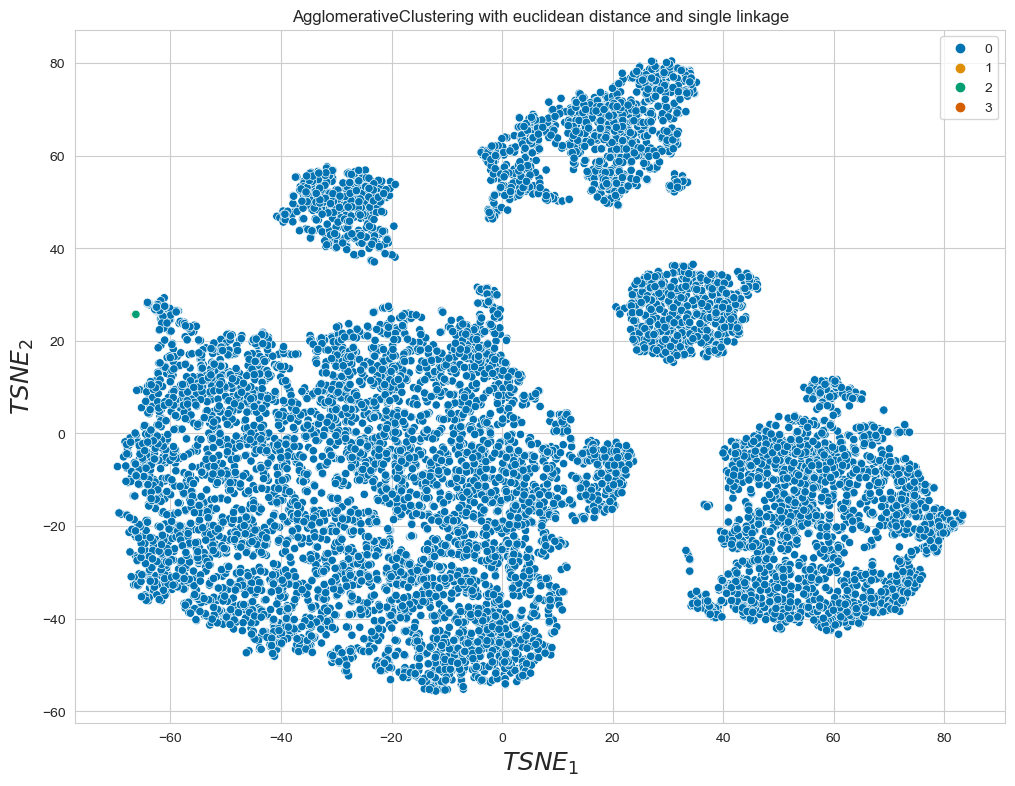

In [24]:
clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='single')
labels = clustering.fit_predict(fc_data)
plot_tsne(fc_data, color=labels)
plt.title(f'AgglomerativeClustering with euclidean distance and single linkage')
plt.show()

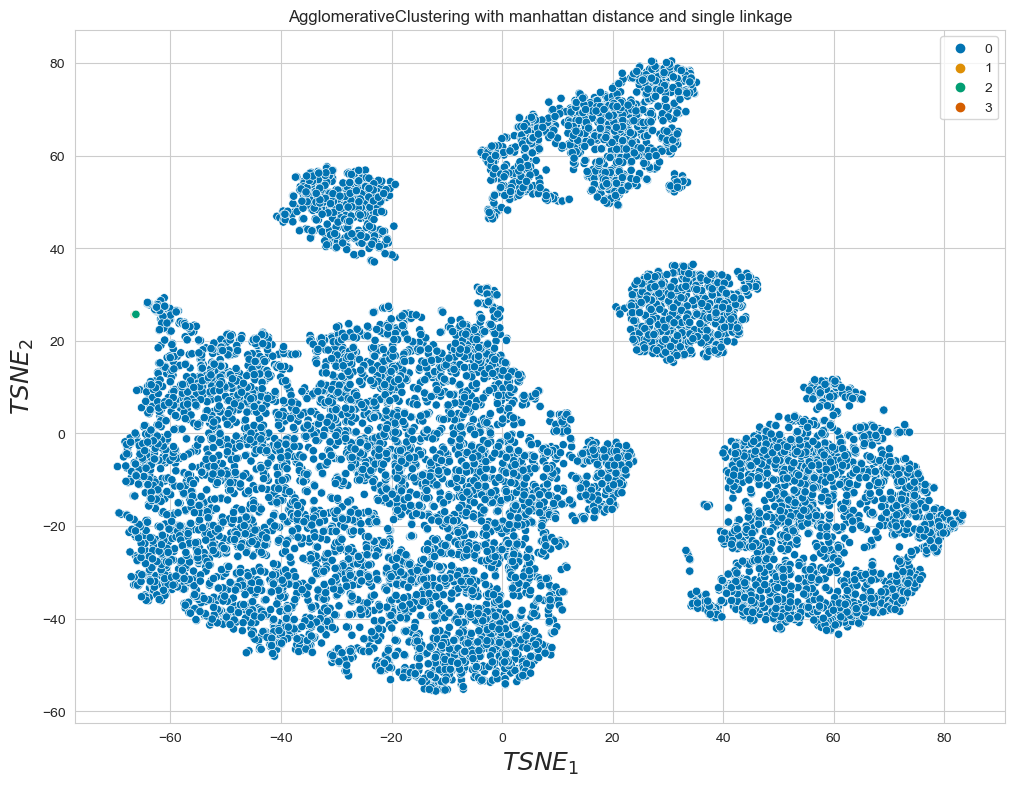

In [25]:
clustering = AgglomerativeClustering(n_clusters=4, metric='manhattan', linkage='single')
labels = clustering.fit_predict(fc_data)
plot_tsne(fc_data, color=labels)
plt.title(f'AgglomerativeClustering with manhattan distance and single linkage')
plt.show()

Не смотря на высокий silhouette_score, все кластеры слились в один( \
На третьем месте по silhouette_score был AgglomerativeClustering с эвклидовым расстоянием и **ward** linkage. Попробуем его. 

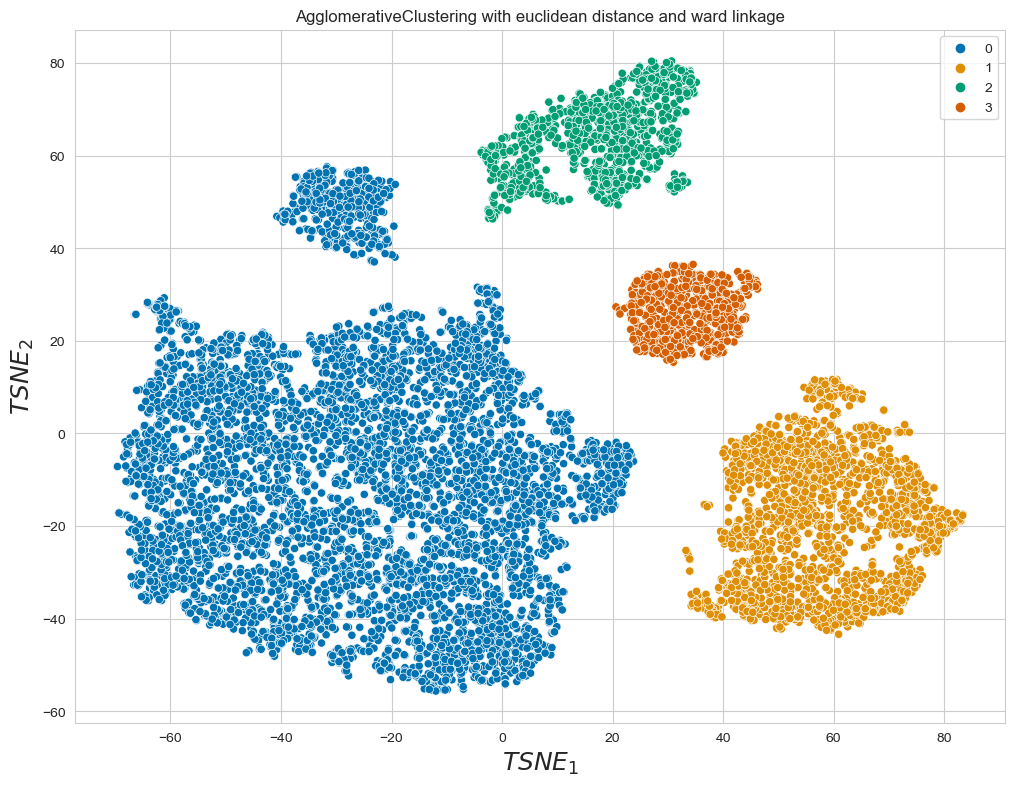

In [35]:
clust = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clust.labels_ = clust.fit_predict(fc_data)
plot_tsne(fc_data, color=clust.labels_)
plt.title(f'AgglomerativeClustering with euclidean distance and ward linkage')
plt.show()

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Да, при AgglomerativeClustering с manhattan или euclidean distance и single linkage.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

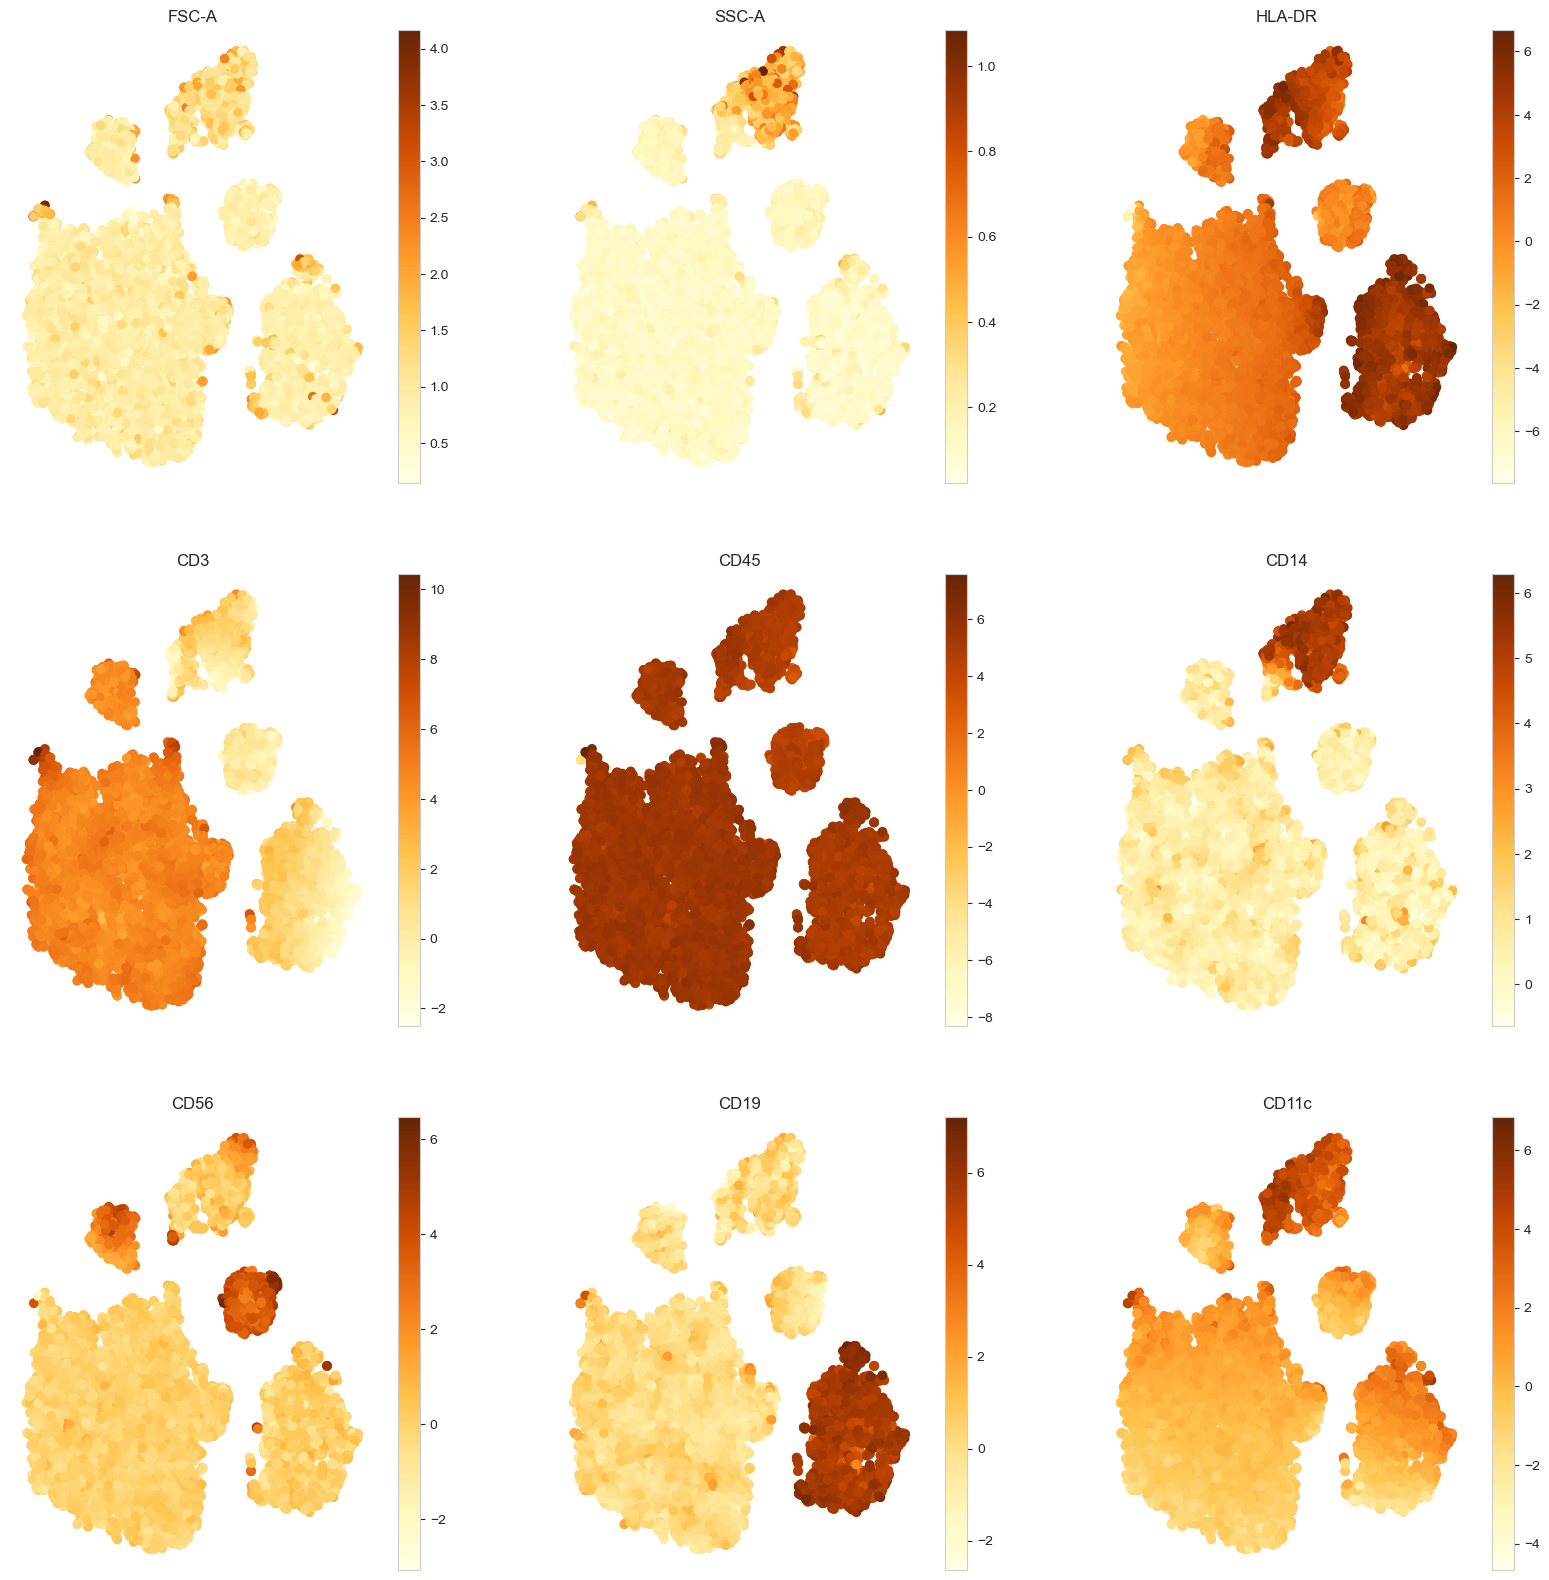

In [27]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [28]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

In [36]:
labeled_fc_data = fc_data.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

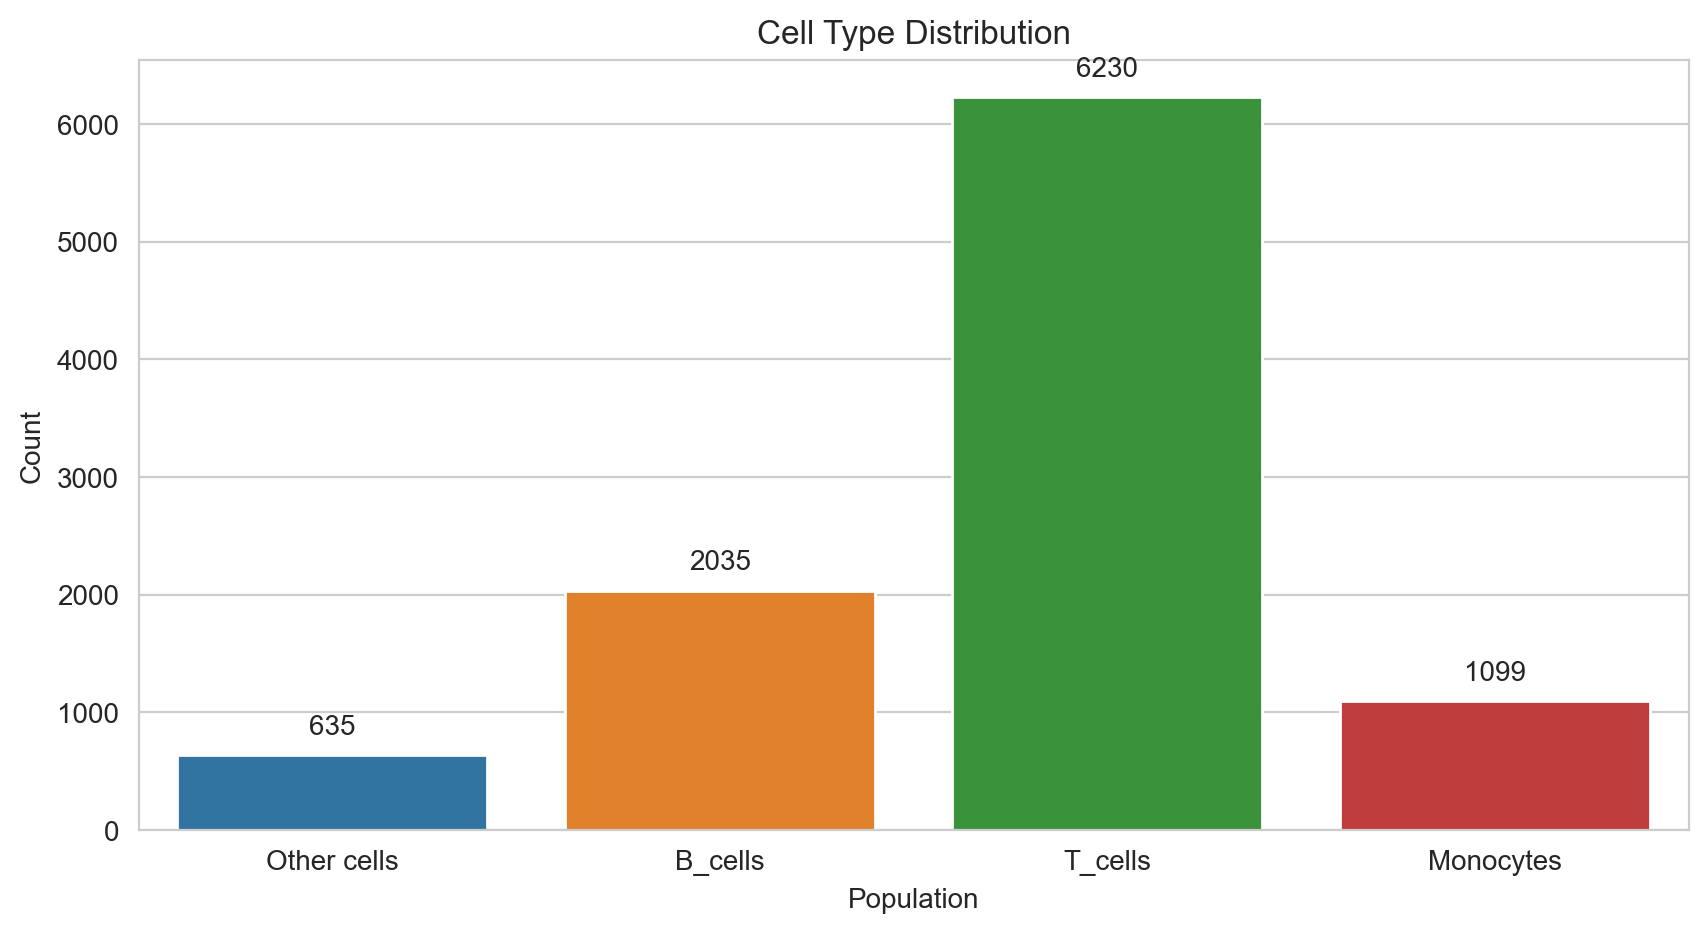

In [37]:
plt.figure(figsize=(10, 5),dpi=200)
sns.countplot(data=labeled_fc_data,x='Population')

# Добавляем текст с числом клеток над каждым столбцом
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Population')
plt.ylabel('Count')
plt.title('Cell Type Distribution')
plt.show()

Больше всего T-клеток.

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [41]:
DATA_PATH = "data\processed"
labeled_fc_data.to_csv(join(DATA_PATH, 'predicted_results.csv'), index=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [39]:
# Подготовка данных для обучения
X = labeled_fc_data.drop('Population', axis=1)
y = labeled_fc_data['Population']  # Используем колонку 'Population' как метки классов

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Создание модели логистической регрессии с балансировкой классов
classifier = LogisticRegression(class_weight='balanced')

# Обучение модели
classifier.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = classifier.predict(X_test)

# Оценка качества модели с использованием f1_score
f1 = round(f1_score(y_test, y_pred, average='macro'), 4)
print(f'F1 Score (Macro): {f1}')

F1 Score (Macro): 1.0


 Модель почти идеально предсказывает все классы в данных, хотя возможно произошло перееобучение.

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Честно говоря, я бы хотела побывать во многих местах весной. Но больше всего на море или в Карелию, когда потеплеет.


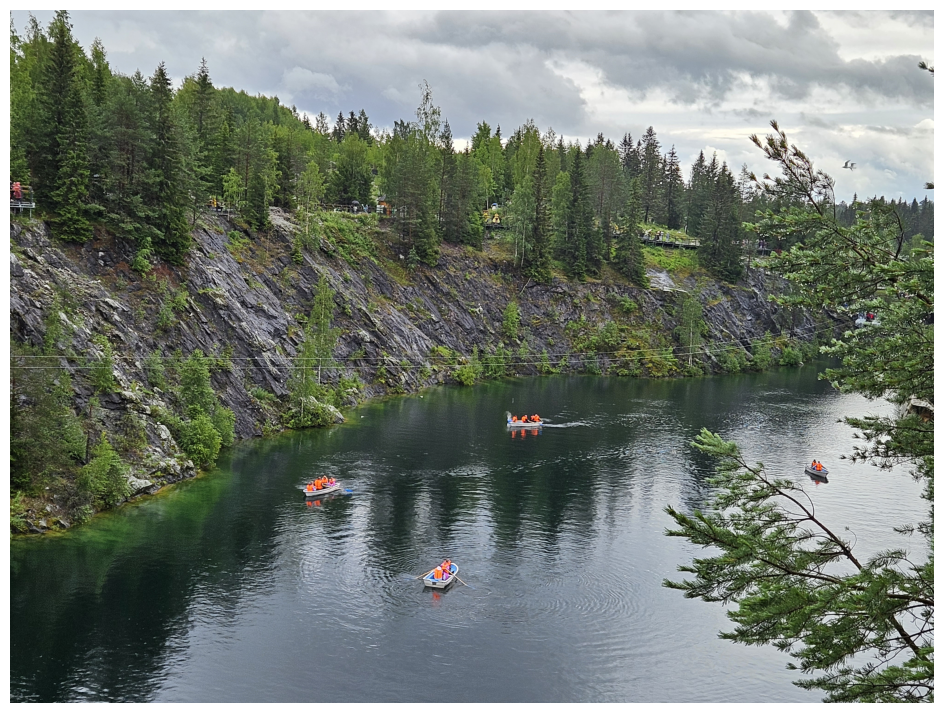

In [40]:
DATA_PATH = "data\additional"
img = mpimg.imread(join(DATA_PATH, 'karelia.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**